In [1]:
import os, json
import numpy as np
import pandas as pd
from pathlib import Path

# 1) WHERE ARE YOUR ARRAYS?
#npz_dir = Path("./checkpoints/long_term_forecast_ETTh1_672_96_AutoTimes_Llama_ETTh1_sl672_ll576_tl96_lr0.0005_bt256_wd0_hd256_hl0_cosTrue_mixTrue_test_0")
npz_dir = Path("/largessd/home/muntasir/Desktop/AutoTimes/test_results/long_term_forecast_ETTh1_672_96_AutoTimes_Llama_ETTh1_sl672_ll576_tl96_lr0.0005_bt256_wd0_hd256_hl0_cosTrue_mixTrue_test_0")
horizons = [96, 192, 336, 720]

# 2) WHERE IS THE CSV?
csv_path = Path("./dataset/ETT-small/ETTh1.csv")
assert npz_dir.exists(), f"Missing npz_dir: {npz_dir}"
assert csv_path.exists(), f"Missing CSV: {csv_path}"

In [2]:
# Load ETTh1.csv
df_raw = pd.read_csv(csv_path)

# First column is the timestamp (e.g., "date"); others are numeric series
time_col = df_raw.columns[0]
data_cols = list(df_raw.columns[1:])  # match dataset order
df_raw[time_col] = pd.to_datetime(df_raw[time_col])
df_raw = df_raw.sort_values(time_col).reset_index(drop=True)

# For fast alignment by timestamp later
df = df_raw.set_index(time_col)[data_cols].copy()

In [3]:
df

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
date,,,,,,,
2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000
...,...,...,...,...,...,...,...
2018-06-26 15:00:00,-1.674,3.550,-5.615,2.132,3.472,1.523,10.904000
2018-06-26 16:00:00,-5.492,4.287,-9.132,2.274,3.533,1.675,11.044000
2018-06-26 17:00:00,2.813,3.818,-0.817,2.097,3.716,1.523,10.271000


In [4]:
def mae(a, b):
    return np.mean(np.abs(a - b))

def mse(a, b):
    return np.mean((a - b) ** 2)

def load_npz_for_h(npz_dir, H):
    path = npz_dir / f"pred_truth_time_len{H}.npz"
    z = np.load(path, allow_pickle=True)
    preds = z["preds"]     # (N, H, C)
    trues = z["trues"]     # (N, H, C)
    times = z["times"] if "times" in z.files else None  # (N, H) int64 ns or None
    return preds, trues, times, path

def times_to_datetime(times):
    """
    times: np.ndarray shape (N, H) with int64 ns (as saved from dataset)
    returns pandas.DatetimeIndex array of shape (N, H)
    """
    flat = pd.to_datetime(times.reshape(-1))
    return flat.values.reshape(times.shape)

In [5]:
for H in horizons:
    preds, trues, times, path = load_npz_for_h(npz_dir, H)
    print(f"\n=== Horizon {H} ===")
    print(f"Loaded: {path.name}")
    print("preds shape:", preds.shape, "trues shape:", trues.shape)
    if times is not None:
        print("times shape:", times.shape)
    assert preds.shape == trues.shape, "preds/trues shape mismatch"
    N, H_chk, C = preds.shape
    assert H_chk == H, f"File horizon {H_chk} != expected {H}"
    global_mae = mae(preds, trues)
    global_mse = mse(preds, trues)
    print(f"MAE(all): {global_mae:.6f}  MSE(all): {global_mse:.6f}")

    # Optional: per-h step MAE across N and C (useful to see horizon degradation)
    per_h_mae = np.mean(np.abs(preds - trues), axis=(0,2))  # shape (H,)
    print("Per-step MAE (first 10):", np.round(per_h_mae[:10], 6))
    


=== Horizon 96 ===
Loaded: pred_truth_time_len96.npz
preds shape: (19495, 96, 1) trues shape: (19495, 96, 1)
times shape: (19495, 96)
MAE(all): 0.430373  MSE(all): 0.403084
Per-step MAE (first 10): [0.353549 0.363933 0.377367 0.396589 0.394801 0.399701 0.417297 0.412093
 0.413887 0.409202]

=== Horizon 192 ===
Loaded: pred_truth_time_len192.npz
preds shape: (18823, 192, 1) trues shape: (18823, 192, 1)
times shape: (18823, 192)
MAE(all): 0.447262  MSE(all): 0.429352
Per-step MAE (first 10): [0.352902 0.363423 0.376748 0.395833 0.393555 0.399128 0.415556 0.410212
 0.411926 0.407749]

=== Horizon 336 ===
Loaded: pred_truth_time_len336.npz
preds shape: (17815, 336, 1) trues shape: (17815, 336, 1)
times shape: (17815, 336)
MAE(all): 0.456258  MSE(all): 0.441671
Per-step MAE (first 10): [0.352036 0.36307  0.376189 0.395463 0.391651 0.398444 0.413443 0.408394
 0.409898 0.405393]

=== Horizon 720 ===
Loaded: pred_truth_time_len720.npz
preds shape: (15127, 720, 1) trues shape: (15127, 720, 1)


In [6]:
path = './test_results/long_term_forecast_ETTh1_672_96_AutoTimes_Llama_ETTh1_sl672_ll576_tl96_lr0.0005_bt256_wd0_hd256_hl0_cosTrue_mixTrue_test_0/pred_truth_time_len336.npz'
z = np.load(path, allow_pickle=True)

In [7]:
z['times']

array([[1508803200000000000, 1508806800000000000, 1508810400000000000,
        ..., 1510002000000000000, 1510005600000000000,
        1510009200000000000],
       [1508806800000000000, 1508810400000000000, 1508814000000000000,
        ..., 1510005600000000000, 1510009200000000000,
        1510012800000000000],
       [1508810400000000000, 1508814000000000000, 1508817600000000000,
        ..., 1510009200000000000, 1510012800000000000,
        1510016400000000000],
       ...,
       [1517954400000000000, 1517958000000000000, 1517961600000000000,
        ..., 1519153200000000000, 1519156800000000000,
        1519160400000000000],
       [1517958000000000000, 1517961600000000000, 1517965200000000000,
        ..., 1519156800000000000, 1519160400000000000,
        1519164000000000000],
       [1517961600000000000, 1517965200000000000, 1517968800000000000,
        ..., 1519160400000000000, 1519164000000000000,
        1519167600000000000]], shape=(17815, 336))

In [9]:
import numpy as np
import pandas as pd
from pathlib import Path

# paths
npz_dir = Path("/largessd/home/muntasir/Desktop/AutoTimes/test_results/long_term_forecast_ETTh1_672_96_AutoTimes_Llama_ETTh1_sl672_ll576_tl96_lr0.0005_bt256_wd0_hd256_hl0_cosTrue_mixTrue_test_0")
csv_path = Path("./dataset/ETT-small/ETTh1.csv")

# load CSV exactly like the dataset: first col = time; others = data cols
df_raw = pd.read_csv(csv_path)
time_col = df_raw.columns[0]
data_cols = list(df_raw.columns[1:])
df_raw[time_col] = pd.to_datetime(df_raw[time_col])
df_raw = df_raw.sort_values(time_col).reset_index(drop=True)
df = df_raw.set_index(time_col)[data_cols]

# your model looks univariate (C=1), target is usually 'OT' in ETTh1:
TARGET = "OT"
assert TARGET in df.columns, f"{TARGET} not found in CSV. Available: {df.columns.tolist()}"

def mae(a, b): return np.mean(np.abs(a - b))
def mse(a, b): return np.mean((a - b) ** 2)

def check_one(npz_path: Path):
    z = np.load(npz_path, allow_pickle=True)
    preds = z["preds"]     # (N,H,C)
    trues = z["trues"]     # (N,H,C)
    times = z["times"]     # (N,H) int64 ns

    N, H, C = preds.shape
    print(f"\n=== {npz_path.name} ===")
    print("preds:", preds.shape, "trues:", trues.shape, "times:", times.shape)

    # 1) basic consistency
    assert trues.shape == preds.shape
    assert times.shape == (N, H)

    # 2) timestamps must exist in CSV index
    ts = pd.to_datetime(times.reshape(-1))      # (N*H,)
    missing = (~ts.isin(df.index)).sum()
    print("timestamps missing from CSV:", missing)
    assert missing == 0, "Some timestamps not found in CSV index."

    # 3) rebuild CSV ground truth for same timestamps and same target column
    y_ref_flat = df[TARGET].reindex(ts).to_numpy()   # (N*H,)
    y_ref = y_ref_flat.reshape(N, H, 1)              # match C=1 (your arrays)
    # If your arrays are multivariate (C>1), adapt to select the same set of columns.

    # 4) exact alignment check (with tolerance)
    same = np.allclose(trues, y_ref, rtol=1e-5, atol=1e-6)
    print("trues match CSV@times:", same)
    if not same:
        diff = np.abs(trues - y_ref)
        i, h, c = np.unravel_index(np.nanargmax(diff), diff.shape)
        print(f" max abs diff {diff[i,h,c]:.6g} at sample={i}, step={h}, var={c}, time={ts[i*H+h]}")
        print("  csv:", y_ref[i,h,c], " vs trues:", trues[i,h,c])

    # 5) recompute metrics from arrays
    print(f"MAE: {mae(preds, trues):.6f}  MSE: {mse(preds, trues):.6f}")

    # 6) (optional) sampling interval sanity: should be hourly
    dt_ns = np.diff(times[0])   # first sample deltas
    unique_steps = np.unique(dt_ns)
    one_hour = np.int64(pd.Timedelta(hours=1).value)
    print("unique Δt (ns) in sample[0]:", unique_steps[:5], "...",
          "(has 1h?)", (one_hour in set(unique_steps)))

# run on all horizons you produced
for npz_path in sorted(npz_dir.glob("pred_truth_time_len*.npz")):
    check_one(npz_path)


=== pred_truth_time_len192.npz ===
preds: (18823, 192, 1) trues: (18823, 192, 1) times: (18823, 192)
timestamps missing from CSV: 0
trues match CSV@times: False
 max abs diff 17.8661 at sample=5417, step=191, var=0, time=2017-11-02 14:00:00
  csv: 14.279999732971191  vs trues: -3.5860684
MAE: 0.447262  MSE: 0.429352
unique Δt (ns) in sample[0]: [3600000000000] ... (has 1h?) True

=== pred_truth_time_len336.npz ===
preds: (17815, 336, 1) trues: (17815, 336, 1) times: (17815, 336)
timestamps missing from CSV: 0
trues match CSV@times: False
 max abs diff 17.8661 at sample=5090, step=230, var=0, time=2017-11-02 14:00:00
  csv: 14.279999732971191  vs trues: -3.5860684
MAE: 0.456258  MSE: 0.441671
unique Δt (ns) in sample[0]: [3600000000000] ... (has 1h?) True

=== pred_truth_time_len720.npz ===
preds: (15127, 720, 1) trues: (15127, 720, 1) times: (15127, 720)
timestamps missing from CSV: 0
trues match CSV@times: False
 max abs diff 17.8661 at sample=4322, step=230, var=0, time=2017-11-02 1

In [15]:
# y_scaled: your saved trues (flattened)
# y_csv: CSV[target] at the same timestamps (flattened)
y_scaled = trues.reshape(-1)          # (N*H,)
y_csv    = y_ref.reshape(-1)          # built from CSV earlier

# Fit y_csv ≈ a * y_scaled + b
a, b = np.polyfit(y_scaled, y_csv, deg=1)
print("affine fit:", a, b)

# If this is just z-scoring, you'd expect a ≈ train_std and b ≈ train_mean
y_csv_hat = a * y_scaled + b
print("RMSE between CSV and affine(y_scaled):", np.sqrt(np.mean((y_csv - y_csv_hat)**2)))

NameError: name 'y_ref' is not defined

In [14]:
df_raw

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000
...,...,...,...,...,...,...,...,...
17415,2018-06-26 15:00:00,-1.674,3.550,-5.615,2.132,3.472,1.523,10.904000
17416,2018-06-26 16:00:00,-5.492,4.287,-9.132,2.274,3.533,1.675,11.044000
17417,2018-06-26 17:00:00,2.813,3.818,-0.817,2.097,3.716,1.523,10.271000
17418,2018-06-26 18:00:00,9.243,3.818,5.472,2.097,3.655,1.432,9.778000


Affine fit (csv ≈ a*true + b): a=-0.3765, b=10.2969
Raw-scale corr(true,csv): -0.3445833134763581


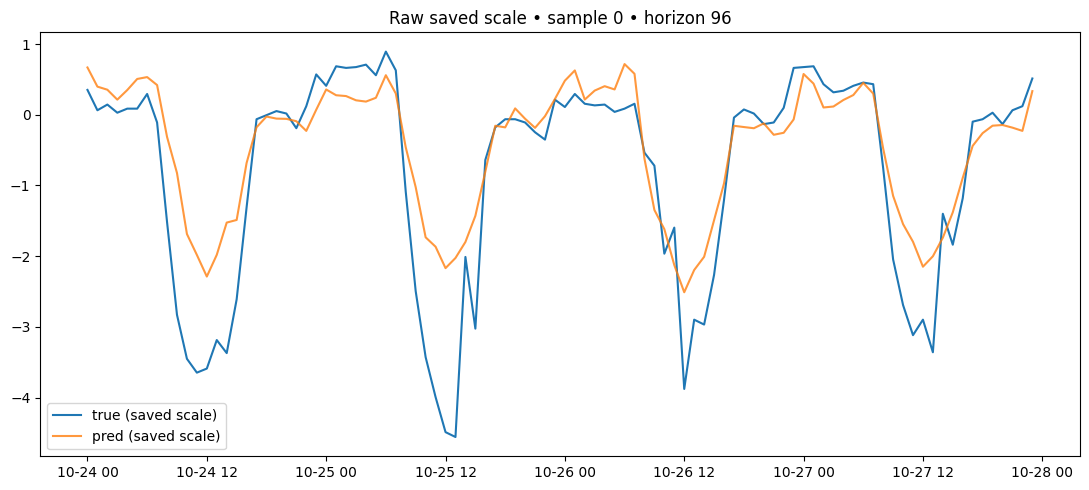

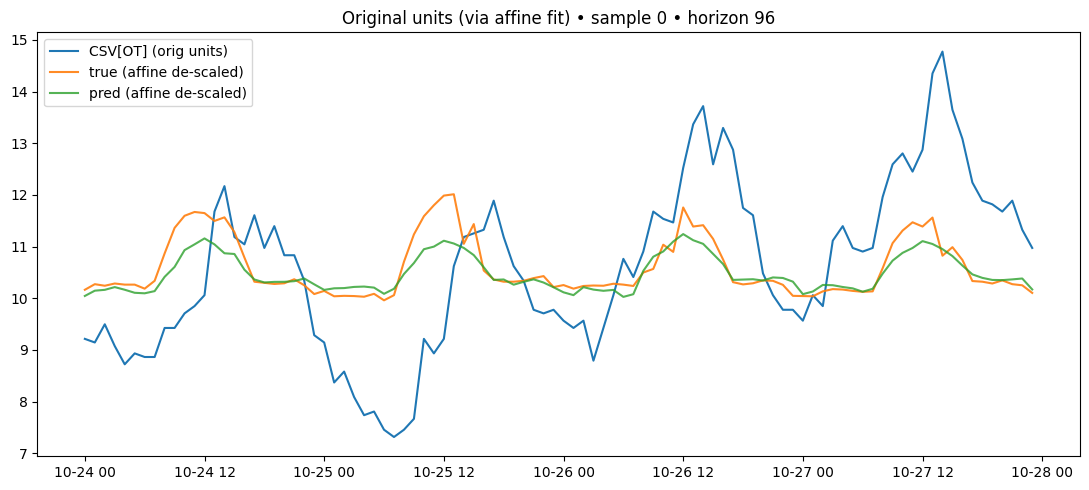

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# --- paths / choices ---
npz_path = Path("./test_results/long_term_forecast_ETTh1_672_96_AutoTimes_Llama_ETTh1_sl672_ll576_tl96_lr0.0005_bt256_wd0_hd256_hl0_cosTrue_mixTrue_test_0/pred_truth_time_len96.npz")  # pick any horizon file
csv_path = Path("./dataset/ETT-small/ETTh1.csv")
TARGET = "OT"
i = 0  # sample index to plot

# --- load arrays ---
z = np.load(npz_path, allow_pickle=True)
preds = z["preds"]   # (N, H, C)
trues = z["trues"]   # (N, H, C)
times = z["times"]   # (N, H)
N, H, C = preds.shape
assert C == 1, "This snippet assumes univariate (C=1); adapt if multivariate."

# --- load CSV like the dataset ---
df_raw = pd.read_csv(csv_path)
time_col = df_raw.columns[0]
df_raw[time_col] = pd.to_datetime(df_raw[time_col])
df_raw = df_raw.sort_values(time_col).reset_index(drop=True)
df = df_raw.set_index(time_col)

# --- pick one sample's horizon window ---
ts = pd.to_datetime(times[i])                # DatetimeIndex-like array length H
y_true = trues[i, :, 0]                      # saved ground truth (likely standardized)
y_pred = preds[i, :, 0]                      # saved preds (same scale as y_true)
y_csv  = df.loc[ts, TARGET].to_numpy()       # CSV values in original units

# --- quick check: are arrays standardized? (csv vs true) ---
# fit an affine map from y_true -> y_csv just for visualization
a, b = np.polyfit(y_true, y_csv, deg=1)
y_true_inv = a * y_true + b
y_pred_inv = a * y_pred + b

print(f"Affine fit (csv ≈ a*true + b): a={a:.4f}, b={b:.4f}")
print("Raw-scale corr(true,csv):", np.corrcoef(y_true, y_csv)[0,1])

# --- PLOTS ---
plt.figure(figsize=(11,5))
plt.plot(ts, y_true, label="true (saved scale)")
plt.plot(ts, y_pred, label="pred (saved scale)", alpha=0.8)
plt.title(f"Raw saved scale • sample {i} • horizon {H}")
plt.legend(); plt.tight_layout()
plt.show()

plt.figure(figsize=(11,5))
plt.plot(ts, y_csv, label=f"CSV[{TARGET}] (orig units)")
plt.plot(ts, y_true_inv, label="true (affine de-scaled)", alpha=0.9)
plt.plot(ts, y_pred_inv, label="pred (affine de-scaled)", alpha=0.8)
plt.title(f"Original units (via affine fit) • sample {i} • horizon {H}")
plt.legend(); plt.tight_layout()
plt.show()

In [17]:
import numpy as np
import pandas as pd
from pathlib import Path

# ---- inputs ----
npz_path = Path("./test_results/long_term_forecast_ETTh1_672_96_AutoTimes_Llama_ETTh1_sl672_ll576_tl96_lr0.0005_bt256_wd0_hd256_hl0_cosTrue_mixTrue_test_0/pred_truth_time_len96.npz")  # pick any horizon file
csv_path = Path("./dataset/ETT-small/ETTh1.csv")

# ---- load arrays ----
z = np.load(npz_path, allow_pickle=True)
preds = z["preds"]   # (N, H, 1)
trues = z["trues"]   # (N, H, 1)
times = z["times"]   # (N, H)
N, H, C = preds.shape
assert C == 1, f"Expected univariate arrays; got C={C}"

# ---- load CSV like the dataset ----
df_raw = pd.read_csv(csv_path)
time_col = df_raw.columns[0]
data_cols = list(df_raw.columns[1:])
df_raw[time_col] = pd.to_datetime(df_raw[time_col])
df_raw = df_raw.sort_values(time_col).reset_index(drop=True)
df = df_raw.set_index(time_col)[data_cols]

# ---- flatten the grid of timestamps and your trues ----
ts = pd.to_datetime(times.reshape(-1))       # (N*H,)
y_true_flat = trues.reshape(-1)              # (N*H,)

# quick guard: all ts must exist
assert (~ts.isin(df.index)).sum() == 0, "Some timestamps not in CSV index!"

results = []
for col in data_cols:
    y_csv_flat = df[col].reindex(ts).to_numpy()   # (N*H,)

    # correlation on saved (standardized) scale
    corr = np.corrcoef(y_true_flat, y_csv_flat)[0, 1]

    # affine fit y_csv ≈ a * y_true + b
    # (robust to standardization — should align if it's the right column)
    a, b = np.polyfit(y_true_flat, y_csv_flat, deg=1)
    y_hat = a * y_true_flat + b
    rmse = np.sqrt(np.mean((y_csv_flat - y_hat)**2))

    results.append((col, corr, rmse, a, b))

# rank by correlation (desc) and RMSE (asc)
top_by_corr = sorted(results, key=lambda x: (-abs(x[1]), x[2]))[:5]
top_by_rmse = sorted(results, key=lambda x: (x[2], -abs(x[1])))[:5]

print("\nTop matches by |corr|:")
for col, corr, rmse, a, b in top_by_corr:
    print(f"  {col:>6s}  corr={corr: .4f}  rmse={rmse: .4f}  a={a: .4f}  b={b: .4f}")

print("\nTop matches by RMSE:")
for col, corr, rmse, a, b in top_by_rmse:
    print(f"  {col:>6s}  corr={corr: .4f}  rmse={rmse: .4f}  a={a: .4f}  b={b: .4f}")

# pick the best candidate (lowest RMSE)
best_col, best_corr, best_rmse, best_a, best_b = min(results, key=lambda x: x[2])
print(f"\n>>> Likely target: {best_col}  (corr={best_corr:.4f}, rmse={best_rmse:.4f})")


Top matches by |corr|:
    HUFL  corr= 0.3804  rmse= 7.0558  a= 2.7571  b= 8.0459
    MUFL  corr= 0.3672  rmse= 6.8911  a= 2.5844  b= 4.6924
    LUFL  corr= 0.2135  rmse= 0.8900  a= 0.1847  b= 3.2860
    HULL  corr= 0.1984  rmse= 1.1925  a= 0.2294  b= 2.9803
    MULL  corr= 0.1744  rmse= 0.9924  a= 0.1669  b= 1.4627

Top matches by RMSE:
    LULL  corr= 0.0392  rmse= 0.2989  a= 0.0111  b= 0.9741
    LUFL  corr= 0.2135  rmse= 0.8900  a= 0.1847  b= 3.2860
    MULL  corr= 0.1744  rmse= 0.9924  a= 0.1669  b= 1.4627
    HULL  corr= 0.1984  rmse= 1.1925  a= 0.2294  b= 2.9803
      OT  corr=-0.0902  rmse= 3.0878  a=-0.2656  b= 4.8146

>>> Likely target: LULL  (corr=0.0392, rmse=0.2989)


In [24]:
# verify_concat_and_scaling.py
import numpy as np
import pandas as pd
from types import SimpleNamespace as NS
from pathlib import Path
import os

# ==== CONFIG ====
CSV_PATH = "./dataset/ETT-small/ETTh1.csv"
NPZ_PATH = "./test_results/long_term_forecast_ETTh1_672_96_AutoTimes_Llama_ETTh1_sl672_ll576_tl96_lr0.0005_bt256_wd0_hd256_hl0_cosTrue_mixTrue_test_0/pred_truth_time_len96.npz"  # e.g. len96/192/336/720
SEQ_LEN, LABEL_LEN = 672, 576  # match your run

# ==== Derive horizon H from filename ====
H = int(Path(NPZ_PATH).stem.split("len")[-1])

# ==== Rebuild test dataset (to get tot_len, enc_in) ====
from data_provider.data_factory import data_provider

args = NS(
    task_name='long_term_forecast',
    is_training=0,
    data='ETTh1',
    root_path=os.path.dirname(CSV_PATH) + "/",   # "./dataset/ETT-small/"
    data_path=os.path.basename(CSV_PATH),        # "ETTh1.csv"
    seq_len=SEQ_LEN, label_len=LABEL_LEN, pred_len=H,
    test_seq_len=SEQ_LEN, test_label_len=LABEL_LEN, test_pred_len=H,
    batch_size=64, num_workers=0, drop_last=True, shuffle=False,
    token_len=SEQ_LEN - LABEL_LEN,   # matches repo logic (672-576=96)
    features='M', target='OT', freq='h',
    seasonal_patterns='none',
    mix_embeds=True, use_amp=False, inverse=False, scale=True, drop_short = True, use_multi_gpu = False
)
test_data, _ = data_provider(args, 'test')
tot_len = test_data.tot_len
enc_in  = test_data.enc_in

print(f"enc_in (num columns)     : {enc_in}")
print(f"tot_len (windows/column) : {tot_len}")
print(f"dataset length           : {len(test_data)} (expect tot_len*enc_in={tot_len*enc_in})")

# ==== Load saved arrays ====
z = np.load(NPZ_PATH, allow_pickle=True)
preds = z["preds"]   # (N, H, 1) scaled
trues = z["trues"]   # (N, H, 1) scaled
times = z["times"]   # (N, H)    int64 ns
N, H_file, C = preds.shape
assert H_file == H, f"File horizon {H_file} != parsed {H}"
assert C == 1, f"This script assumes univariate arrays; got C={C}"
print(f"Saved arrays: N={N}, H={H}, C={C} (expect N == tot_len*enc_in={tot_len*enc_in})")

# ==== Load CSV and compute per-column train mean/std exactly like dataset ====
df_raw = pd.read_csv(CSV_PATH)
time_col = df_raw.columns[0]
data_cols = list(df_raw.columns[1:])
df_raw[time_col] = pd.to_datetime(df_raw[time_col])
df_raw = df_raw.sort_values(time_col).reset_index(drop=True)
df = df_raw.set_index(time_col)[data_cols]

# Dataset uses first year = 12*30*24 rows as "train split" for scaling
B0, B1 = 0, 12 * 30 * 24   # 8640 hours
train_df = df.iloc[B0:B1]
means = train_df.mean(axis=0).to_numpy()                 # population mean
scales = train_df.std(axis=0, ddof=0).replace(0, 1e-12)  # population std; guard zeros
# (If you're on very old pandas, use np.std(train_df.values, axis=0) instead)

print("Columns:", data_cols)
print("Means shape:", means.shape, "Scales shape:", scales.shape)

# ==== Map each saved sample i -> (feat_id, s_begin) and column ====
feat_id = (np.arange(N) // tot_len).astype(int)     # which column this sample belongs to
s_begin = (np.arange(N) %  tot_len).astype(int)     # which window start inside that column

# Quick sanity at block boundaries
for j in range(min(enc_in, 4)):
    i0 = j * tot_len
    print(f"Block start i={i0} -> feat_id={feat_id[i0]}, col={data_cols[feat_id[i0]]}, s_begin={s_begin[i0]}")

# ==== Verify alignment on scaled space ====
# Build reference from CSV for each sample's own column, then standardize with that column's stats
max_abs_diff = 0.0
mean_abs_diffs = []

# Sample a handful + a few random
rng = np.random.default_rng(0)
indices = []
for j in range(enc_in):
    i0 = j * tot_len
    if i0 < N: indices.append(i0)
indices += rng.choice(N, size=min(10, N), replace=False).tolist()
indices = sorted(set(indices))[:min(25, len(set(indices)))]

for i in indices:
    j = feat_id[i]
    col = data_cols[j]
    ts_i = pd.to_datetime(times[i])                 # (H,)
    y_csv = df[col].reindex(ts_i).to_numpy()        # original units
    y_csv_scaled = (y_csv - means[j]) / scales[j]   # standardized for this column
    diff = np.abs(trues[i, :, 0] - y_csv_scaled)    # compare to saved trues
    max_abs_diff = max(max_abs_diff, float(diff.max()))
    mean_abs_diffs.append(float(diff.mean()))

print(f"\nScaled-space check -> max abs diff across inspected samples: {max_abs_diff:.6g}")
print(f"Scaled-space check -> mean(abs diff) across samples         : {np.mean(mean_abs_diffs):.6g}")

# ==== Count how many samples per column (should each be tot_len) ====
counts = pd.Series(feat_id).map(lambda x: data_cols[x]).value_counts().sort_index()
print("\nCounts per column (expect each == tot_len):")
print(counts)

# ==== Optional: invert one sample to original units and compare visually ====
try:
    import matplotlib.pyplot as plt
    i = indices[0]
    j = feat_id[i]; col = data_cols[j]
    ts_i = pd.to_datetime(times[i])
    y_csv = df[col].reindex(ts_i).to_numpy()
    y_true = trues[i, :, 0] * scales[j] + means[j]
    y_pred = preds[i, :, 0] * scales[j] + means[j]

    plt.figure(figsize=(10,4))
    plt.plot(ts_i, y_csv, label=f"CSV[{col}] (orig)")
    plt.plot(ts_i, y_true, label="true (inverted)", alpha=0.9)
    plt.plot(ts_i, y_pred, label="pred (inverted)", alpha=0.8)
    plt.title(f"Sample i={i}, col={col} • H={H}")
    plt.legend(); plt.tight_layout(); plt.show()
except Exception as e:
    print("Plot skipped:", e)

test 19495
enc_in (num columns)     : 7
tot_len (windows/column) : 2785
dataset length           : 19495 (expect tot_len*enc_in=19495)
Saved arrays: N=19495, H=96, C=1 (expect N == tot_len*enc_in=19495)
Columns: ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']
Means shape: (7,) Scales shape: (7,)
Block start i=0 -> feat_id=0, col=HUFL, s_begin=0
Block start i=2785 -> feat_id=1, col=HULL, s_begin=0
Block start i=5570 -> feat_id=2, col=MUFL, s_begin=0
Block start i=8355 -> feat_id=3, col=MULL, s_begin=0

Scaled-space check -> max abs diff across inspected samples: 16.5057
Scaled-space check -> mean(abs diff) across samples         : 4.3938

Counts per column (expect each == tot_len):
HUFL    2785
HULL    2785
LUFL    2785
LULL    2785
MUFL    2785
MULL    2785
OT      2785
Name: count, dtype: int64


In [30]:
df_raw.iloc[-2785+4]

date    2018-03-02 23:00:00
HUFL                 10.047
HULL                  0.737
MUFL                  7.747
MULL                 -0.071
LUFL                  2.102
LULL                  0.487
OT                     4.08
Name: 14639, dtype: object

In [35]:
# verify_ot_block.py
import numpy as np
import pandas as pd
from pathlib import Path
from types import SimpleNamespace as NS
from data_provider.data_factory import data_provider
from sklearn.preprocessing import StandardScaler
import os

# ==== CONFIG ====
CSV_PATH = "./dataset/ETT-small/ETTh1.csv"
NPZ_PATH = "./test_results/long_term_forecast_ETTh1_672_96_AutoTimes_Llama_ETTh1_sl672_ll576_tl96_lr0.0005_bt256_wd0_hd256_hl0_cosTrue_mixTrue_test_0/pred_truth_time_len96.npz"  # e.g. len96/192/336/720
SEQ_LEN, LABEL_LEN = 672, 576  # match your run

# ==== Derive horizon H from filename ====
H = int(Path(NPZ_PATH).stem.split("len")[-1])

# ==== Rebuild test dataset (to get tot_len, enc_in) ====
from data_provider.data_factory import data_provider

args = NS(
    task_name='long_term_forecast',
    is_training=0,
    data='ETTh1',
    root_path=os.path.dirname(CSV_PATH) + "/",   # "./dataset/ETT-small/"
    data_path=os.path.basename(CSV_PATH),        # "ETTh1.csv"
    seq_len=SEQ_LEN, label_len=LABEL_LEN, pred_len=H,
    test_seq_len=SEQ_LEN, test_label_len=LABEL_LEN, test_pred_len=H,
    batch_size=64, num_workers=0, drop_last=True, shuffle=False,
    token_len=SEQ_LEN - LABEL_LEN,   # matches repo logic (672-576=96)
    features='M', target='OT', freq='h',
    seasonal_patterns='none',
    mix_embeds=True, use_amp=False, inverse=False, scale=True, drop_short = True, use_multi_gpu = False
)
test_data, _ = data_provider(args, 'test')
tot_len = test_data.tot_len
enc_in  = test_data.enc_in

# ==== Load saved arrays ====
z = np.load(NPZ_PATH, allow_pickle=True)
preds = z["preds"]   # (N,H,1) scaled
trues = z["trues"]   # (N,H,1) scaled
times = z["times"]   # (N,H)    int64 ns
N = preds.shape[0]

print(f"N={N}, H={H}, enc_in={enc_in}, tot_len={tot_len} (expect N == enc_in*tot_len={enc_in*tot_len})")

# ==== Load CSV and get column order ====
df_raw = pd.read_csv(CSV_PATH)
time_col = df_raw.columns[0]
data_cols = list(df_raw.columns[1:])
df_raw[time_col] = pd.to_datetime(df_raw[time_col])
df_raw = df_raw.sort_values(time_col).reset_index(drop=True)
df = df_raw.set_index(time_col)[data_cols]
print("Columns order:", data_cols)

# ==== Fit scaler on TRAIN SPLIT exactly like the dataset ====
B0, B1 = 0, 12 * 30 * 24  # first 8640 rows
scaler = StandardScaler()
scaler.fit(df.iloc[B0:B1].values.astype(np.float64))  # (rows, features)
means  = scaler.mean_      # (enc_in,)
scales = scaler.scale_     # (enc_in,)

# ==== Locate the OT block ====
j_ot = data_cols.index("OT")
i_start = j_ot * tot_len
i_end   = i_start + tot_len
print(f"OT block index range: [{i_start}, {i_end})  (size={tot_len})")

# ==== Vectorized check for the whole OT block ====
times_block = times[i_start:i_end]                 # (tot_len, H)
ts_flat = pd.to_datetime(times_block.reshape(-1))  # (tot_len*H,)
y_csv_flat = df["OT"].reindex(ts_flat).to_numpy()  # original units
y_csv = y_csv_flat.reshape(tot_len, H)             # (tot_len, H)

# standardize with OT's train mean/std
mu, sig = float(means[j_ot]), float(scales[j_ot])
y_csv_scaled = (y_csv - mu) / sig

# compare with saved trues (scaled)
trues_ot = trues[i_start:i_end, :, 0]              # (tot_len, H)
abs_diff = np.abs(trues_ot - y_csv_scaled)
print(f"OT scaled-space: max|diff|={abs_diff.max():.6g}, mean|diff|={abs_diff.mean():.6g}")


test 19495
N=19495, H=96, enc_in=7, tot_len=2785 (expect N == enc_in*tot_len=19495)
Columns order: ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']
OT block index range: [16710, 19495)  (size=2785)
OT scaled-space: max|diff|=1.13776e-07, mean|diff|=2.95808e-08


In [37]:
trues_ot = trues[i_start:i_end, :, 0]  
preds_ot = preds[i_start:i_end, :, 0] 
mae(trues_ot,preds_ot)


np.float32(0.18589339)

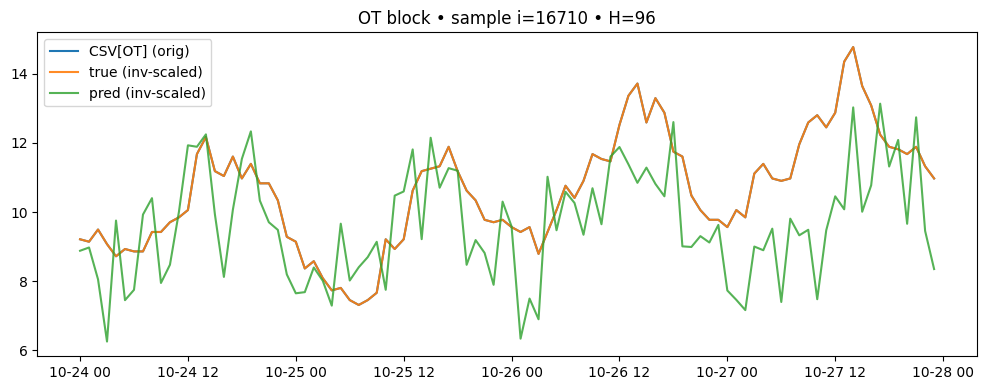

In [52]:
import matplotlib.pyplot as plt
i = i_start  # first OT sample
ts_i = pd.to_datetime(times[i])
y_csv_i = df["OT"].reindex(ts_i).to_numpy()
y_true_i = trues[i, :, 0] * sig + mu 
y_pred_i = preds[i, :, 0] * sig + mu

plt.figure(figsize=(10,4))
plt.plot(ts_i, y_csv_i, label="CSV[OT] (orig)")
plt.plot(ts_i, y_true_i, label="true (inv-scaled)", alpha=0.9)
plt.plot(ts_i, y_pred_i, label="pred (inv-scaled)", alpha=0.8)
plt.title(f"OT block • sample i={i} • H={H}")
plt.legend(); plt.tight_layout(); plt.show()

In [48]:
print(mae(preds[i, :, 0] * sig + mu,y_csv_i))
print(mse(preds[i, :, 0] * sig + mu,y_csv_i))

1.4505752126375835
3.124955456188824


In [49]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import StandardScaler

# -------- CONFIG --------
CSV_PATH = "./dataset/ETT-small/ETTh1.csv"
NPZ_PATH = "./test_results/long_term_forecast_ETTh1_672_96_AutoTimes_Llama_ETTh1_sl672_ll576_tl96_lr0.0005_bt256_wd0_hd256_hl0_cosTrue_mixTrue_test_0/pred_truth_time_len96.npz"  # e.g. len96/192/336/720
SEQ_LEN, LABEL_LEN = 672, 576

def mae(a, b): return float(np.mean(np.abs(a - b)))
def mse(a, b): return float(np.mean((a - b) ** 2))

# -------- Load arrays --------
z = np.load(NPZ_PATH, allow_pickle=True)
preds = z["preds"]   # (N, H, 1)  scaled
trues = z["trues"]   # (N, H, 1)  scaled
times = z["times"]   # (N, H)     int64 ns
N, H, C = preds.shape
assert C == 1, C

# -------- Load CSV like the dataset --------
df_raw = pd.read_csv(CSV_PATH)
time_col = df_raw.columns[0]
data_cols = list(df_raw.columns[1:])
df_raw[time_col] = pd.to_datetime(df_raw[time_col])
df_raw = df_raw.sort_values(time_col).reset_index(drop=True)
df = df_raw.set_index(time_col)[data_cols]
enc_in = len(data_cols)

# -------- Compute test-slice-aware tot_len (exactly like Dataset_ETT_hour) --------
B_train = 12 * 30 * 24   # 8640 rows
B_val   =  4 * 30 * 24   # 2880 rows
border1 = (B_train + B_val) - SEQ_LEN                # start idx for test slice
border2 =  B_train + 2 * B_val                       # end idx for test slice
len_test = border2 - border1
tot_len = len_test - SEQ_LEN - H + 1
assert N == enc_in * tot_len, (N, enc_in, tot_len)

# -------- Fit scaler on TRAIN split (matches repo) --------
scaler = StandardScaler()
scaler.fit(df.iloc[:B_train].values.astype(np.float64))
means, scales = scaler.mean_, scaler.scale_

# -------- Evaluate per variable --------
rows = []
for j, col in enumerate(data_cols):
    i0, i1 = j * tot_len, (j + 1) * tot_len
    mu, sig = float(means[j]), float(scales[j])

    # (A) build CSV reference for this variable at the saved timestamps
    ts_flat = pd.to_datetime(times[i0:i1].reshape(-1))
    y_csv_flat = df[col].reindex(ts_flat).to_numpy()
    y_csv = y_csv_flat.reshape(tot_len, H)  # (tot_len, H) original units

    # (B) predictions/trues in original units
    y_pred = preds[i0:i1, :, 0] * sig + mu
    y_true = trues[i0:i1, :, 0] * sig + mu

    # (C) metrics in original units (vs CSV or vs y_true — they should be equal)
    mae_orig = mae(y_pred, y_csv)     # preferred: model vs CSV ground-truth
    mse_orig = mse(y_pred, y_csv)

    # (D) metrics in scaled space (sanity check)
    y_csv_scaled = (y_csv - mu) / sig
    mae_scaled = mae(preds[i0:i1, :, 0], y_csv_scaled)
    mse_scaled = mse(preds[i0:i1, :, 0], y_csv_scaled)

    rows.append((col, mae_orig, mse_orig, mae_scaled, mse_scaled))

# -------- Summary table --------
summary = pd.DataFrame(rows, columns=["variable", "MAE_orig", "MSE_orig", "MAE_scaled", "MSE_scaled"])
summary_sorted = summary.sort_values("MAE_orig").reset_index(drop=True)
print(summary_sorted)

# -------- Overall macro metrics (all variables combined) --------
# Original units: stack everything then compare to CSV reference concatenated
mae_all = mae(
    np.vstack([
        (preds[j*tot_len:(j+1)*tot_len, :, 0] * scales[j] + means[j]).reshape(-1, H)
        for j in range(enc_in)
    ]),
    np.vstack([
        df[data_cols[j]].reindex(pd.to_datetime(times[j*tot_len:(j+1)*tot_len].reshape(-1))).to_numpy().reshape(tot_len, H)
        for j in range(enc_in)
    ])
)
mse_all = mse(
    np.vstack([
        (preds[j*tot_len:(j+1)*tot_len, :, 0] * scales[j] + means[j]).reshape(-1, H)
        for j in range(enc_in)
    ]),
    np.vstack([
        df[data_cols[j]].reindex(pd.to_datetime(times[j*tot_len:(j+1)*tot_len].reshape(-1))).to_numpy().reshape(tot_len, H)
        for j in range(enc_in)
    ])
)
print("\nOverall (all variables, original units):")
print(f"MAE_all={mae_all:.6f}  MSE_all={mse_all:.6f}")

  variable  MAE_orig   MSE_orig  MAE_scaled  MSE_scaled
0     LULL  0.186895   0.057473    0.296547    0.144697
1     LUFL  0.560822   0.586061    0.547934    0.559433
2     MULL  0.615753   0.691348    0.319643    0.186300
3     HULL  0.765029   1.025236    0.366024    0.234686
4       OT  1.705849   4.863778    0.185893    0.057759
5     MUFL  3.548228  25.001314    0.642935    0.820870
6     HUFL  3.799412  27.633370    0.653634    0.817844

Overall (all variables, original units):
MAE_all=1.597427  MSE_all=8.551226


In [50]:
import numpy as np, pandas as pd
from pathlib import Path
from sklearn.preprocessing import StandardScaler

# ---- CONFIG ----
CSV_PATH = "./dataset/ETT-small/ETTh1.csv"
NPZ_PATH = "./test_results/long_term_forecast_ETTh1_672_96_AutoTimes_Llama_ETTh1_sl672_ll576_tl96_lr0.0005_bt256_wd0_hd256_hl0_cosTrue_mixTrue_test_0/pred_truth_time_len96.npz"  # e.g. len96/192/336/720
SEQ_LEN, LABEL_LEN = 672, 576

def mae(a, b): return float(np.mean(np.abs(a - b)))
def mse(a, b): return float(np.mean((a - b) ** 2))

# ---- Load saved arrays ----
z = np.load(NPZ_PATH, allow_pickle=True)
preds = z["preds"]   # (N,H,1)  (scaled)
trues = z["trues"]   # (N,H,1)  (scaled)
times = z["times"]   # (N,H)    int64 ns
N, H, C = preds.shape
assert C == 1

# ---- Load CSV like the dataset ----
df_raw = pd.read_csv(CSV_PATH)
time_col = df_raw.columns[0]
data_cols = list(df_raw.columns[1:])
df_raw[time_col] = pd.to_datetime(df_raw[time_col])
df_raw = df_raw.sort_values(time_col).reset_index(drop=True)
df = df_raw.set_index(time_col)[data_cols]
enc_in = len(data_cols)

# ---- Test-slice-aware tot_len (matches Dataset_ETT_hour) ----
B_train = 12 * 30 * 24  # 8640
B_val   =  4 * 30 * 24  # 2880
border1 = (B_train + B_val) - SEQ_LEN
border2 =  (B_train + 2*B_val)
len_test = border2 - border1
tot_len = len_test - SEQ_LEN - H + 1
assert N == enc_in * tot_len, (N, enc_in, tot_len)

# ---- Fit scaler on TRAIN split to inverse-scale each variable ----
scaler = StandardScaler()
scaler.fit(df.iloc[:B_train].values.astype(np.float64))
means, scales = scaler.mean_, scaler.scale_

# ---- Compute MAE/MSE in ORIGINAL UNITS, per variable + overall ----
per_var = []
sum_abs_err = 0.0
sum_sq_err  = 0.0
count_total = 0

# (Optional) per-horizon (original units) aggregated across variables:
mae_sum_H = np.zeros(H, dtype=np.float64)
mse_sum_H = np.zeros(H, dtype=np.float64)
count_H   = np.zeros(H, dtype=np.int64)

for j, col in enumerate(data_cols):
    i0, i1 = j * tot_len, (j + 1) * tot_len
    mu, sig = float(means[j]), float(scales[j])

    # CSV ground truth for this variable at your saved timestamps
    ts_flat = pd.to_datetime(times[i0:i1].reshape(-1))
    y_csv_flat = df[col].reindex(ts_flat).to_numpy()
    y_csv = y_csv_flat.reshape(tot_len, H)  # original units

    # Inverse-scale your preds/trues to original units
    y_pred = preds[i0:i1, :, 0] * sig + mu
    # y_true = trues[i0:i1, :, 0] * sig + mu   # optional (not needed to compute MAE vs CSV)

    # Per-variable metrics (original units) vs CSV
    mae_orig = mae(y_pred, y_csv)
    mse_orig = mse(y_pred, y_csv)
    per_var.append((col, mae_orig, mse_orig))

    # Accumulate overall numerators (original units)
    diff = y_pred - y_csv
    sum_abs_err += np.abs(diff).sum()
    sum_sq_err  += (diff ** 2).sum()
    count_total += diff.size

    # (Optional) per-horizon accumulation (original units)
    mae_sum_H += np.abs(diff).sum(axis=0)   # sum over windows for each horizon step
    mse_sum_H += (diff**2).sum(axis=0)
    count_H   += diff.shape[0]              # +tot_len for each horizon step

# ---- Results ----
per_var_df = pd.DataFrame(per_var, columns=["variable","MAE_orig","MSE_orig"]).sort_values("variable")
MAE_all = sum_abs_err / count_total
MSE_all = sum_sq_err  / count_total

print(per_var_df)
print(f"\nOverall (original units): MAE_all={MAE_all:.6f}  MSE_all={MSE_all:.6f}")

# Per-horizon MAE/MSE in original units (across ALL variables)
mae_per_h = mae_sum_H / count_H
mse_per_h = mse_sum_H / count_H
print("\nPer-horizon MAE (orig units) first 10:", np.round(mae_per_h[:10], 6))
print("Per-horizon MSE (orig units) first 10:", np.round(mse_per_h[:10], 6))

  variable  MAE_orig   MSE_orig
0     HUFL  3.799412  27.633370
1     HULL  0.765029   1.025236
4     LUFL  0.560822   0.586061
5     LULL  0.186895   0.057473
2     MUFL  3.548228  25.001314
3     MULL  0.615753   0.691348
6       OT  1.705849   4.863778

Overall (original units): MAE_all=1.597427  MSE_all=8.551226

Per-horizon MAE (orig units) first 10: [1.275091 1.315188 1.372019 1.452735 1.438713 1.456783 1.533653 1.511585
 1.514032 1.494965]
Per-horizon MSE (orig units) first 10: [5.363323 5.86789  6.639908 7.363296 7.206388 7.249431 7.726789 7.507183
 7.411566 7.354074]


OT block index range: [16710, 19495) (size=2785)


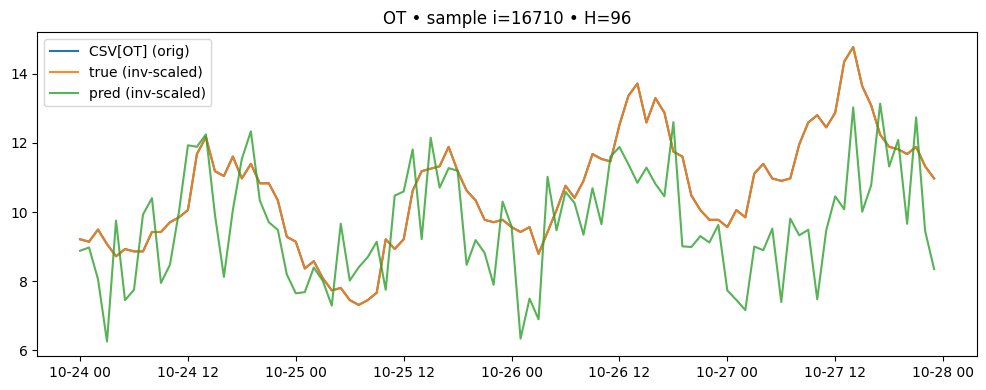

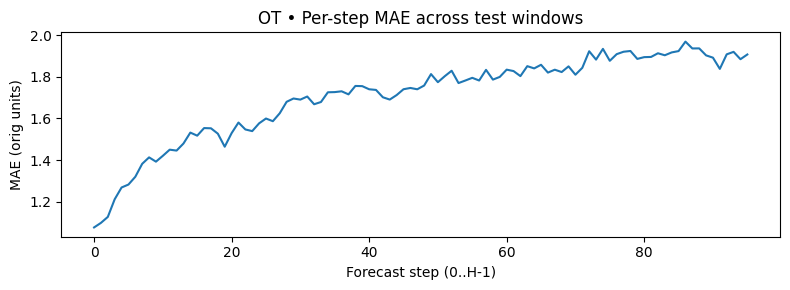

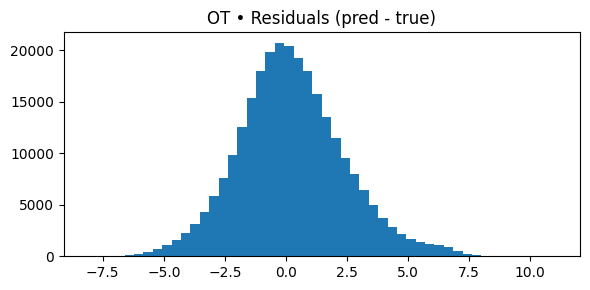

In [2]:
# visualize_ot_fixed.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler

CSV_PATH = "./dataset/ETT-small/ETTh1.csv"
NPZ_PATH = "./test_results/long_term_forecast_ETTh1_672_96_AutoTimes_Llama_ETTh1_sl672_ll576_tl96_lr0.0005_bt256_wd0_hd256_hl0_cosTrue_mixTrue_test_0/pred_truth_time_len96.npz"  # e.g. len96/192/336/720
SEQ_LEN, LABEL_LEN = 672, 576

# --- Load arrays ---
z = np.load(NPZ_PATH, allow_pickle=True)
preds = z["preds"]   # (N,H,1) scaled
trues = z["trues"]   # (N,H,1) scaled
times = z["times"]   # (N,H)
N, H, C = preds.shape
assert C == 1

# --- Load CSV like the dataset ---
df_raw = pd.read_csv(CSV_PATH)
time_col = df_raw.columns[0]
data_cols = list(df_raw.columns[1:])
df_raw[time_col] = pd.to_datetime(df_raw[time_col])
df_raw = df_raw.sort_values(time_col).reset_index(drop=True)
df = df_raw.set_index(time_col)[data_cols]

enc_in = len(data_cols)

# --- Compute test-slice-aware tot_len exactly like Dataset_ETT_hour ---
B_train = 12 * 30 * 24            # 8640
B_val   = 4  * 30 * 24            # 2880
# borders for test split (index 2):
border1 = (B_train + B_val) - SEQ_LEN
border2 = (B_train + 2*B_val)     # = 12*30*24 + 8*30*24
len_test = border2 - border1
tot_len  = len_test - SEQ_LEN - H + 1

assert N == enc_in * tot_len, (N, enc_in, tot_len)

# --- Fit scaler on TRAIN split (matches repo) ---
scaler = StandardScaler()
scaler.fit(df.iloc[:B_train].values.astype(np.float64))
means, scales = scaler.mean_, scaler.scale_

# --- Locate OT block ---
j_ot = data_cols.index("OT")
i_start, i_end = j_ot * tot_len, (j_ot + 1) * tot_len
print(f"OT block index range: [{i_start}, {i_end}) (size={tot_len})")

# --- Build OT arrays in original units (vectorized) ---
ts_flat = pd.to_datetime(times[i_start:i_end].reshape(-1))
y_csv_flat = df["OT"].reindex(ts_flat).to_numpy()
y_csv = y_csv_flat.reshape(tot_len, H)

mu, sig = float(means[j_ot]), float(scales[j_ot])
y_true = trues[i_start:i_end, :, 0] * sig + mu
y_pred = preds[i_start:i_end, :, 0] * sig + mu

# ---------------------- VISUALS ----------------------
# 1) One sample overlay
i = i_start
ts_i    = pd.to_datetime(times[i])
y_csv_i = df["OT"].reindex(ts_i).to_numpy()
y_true_i = trues[i, :, 0] * sig + mu
y_pred_i = preds[i, :, 0] * sig + mu

plt.figure(figsize=(10,4))
plt.plot(ts_i, y_csv_i, label="CSV[OT] (orig)")
plt.plot(ts_i, y_true_i, label="true (inv-scaled)", alpha=0.9)
plt.plot(ts_i, y_pred_i, label="pred (inv-scaled)", alpha=0.8)
plt.title(f"OT • sample i={i} • H={H}")
plt.legend(); plt.tight_layout(); plt.show()

# 2) Per-step MAE across OT block
mae_per_h = np.mean(np.abs(y_pred - y_true), axis=0)
plt.figure(figsize=(8,3))
plt.plot(np.arange(H), mae_per_h)
plt.xlabel("Forecast step (0..H-1)")
plt.ylabel("MAE (orig units)")
plt.title("OT • Per-step MAE across test windows")
plt.tight_layout(); plt.show()

# 3) Residual histogram
residuals = (y_pred - y_true).reshape(-1)
plt.figure(figsize=(6,3))
plt.hist(residuals, bins=50)
plt.title("OT • Residuals (pred - true)"); plt.tight_layout(); plt.show()

In [1]:
import numpy as np, glob, os

def mae(a,b): return float(np.mean(np.abs(a-b)))
def mse(a,b): return float(np.mean((a-b)**2))

test_dir = "./test_results/long_term_forecast_ETTh1_672_96_AutoTimes_Llama_ETTh1_sl672_ll576_tl96_lr0.0005_bt256_wd0_hd256_hl0_cosTrue_mixTrue_test_0"

for path in sorted(glob.glob(os.path.join(test_dir, "pred_truth_time_len*.npz"))):
    z = np.load(path)
    preds, trues = z["preds"], z["trues"]           # both scaled (z-scores)
    m_mae = mae(preds, trues)
    m_mse = mse(preds, trues)
    print(os.path.basename(path), f"MAE={m_mae:.6f}  MSE={m_mse:.6f}")

pred_truth_time_len192.npz MAE=0.447262  MSE=0.429352
pred_truth_time_len336.npz MAE=0.456258  MSE=0.441671
pred_truth_time_len720.npz MAE=0.478334  MSE=0.465662
pred_truth_time_len96.npz MAE=0.430373  MSE=0.403084
